# Assessing Climate Change-Related Risks in the Supply Chain

Author: Hasan Guler

#### Assumptions

Hazard exposure levels are constant across a country

The multiplication of exposure and vulnerability accurately reflects the overall risk

Ratings for exposure range from 0 to 100 and other values are removed

The tier 1 suppliers for each raw material remain constant between the baseline and future scenarios.

Material vulnerability ratings do not change significantly over time.

In [46]:
#importing necessary packages for this project

##data managament

import os #accessing directories
import numpy as np #for numeric calculations with more complex data structures
import pandas as pd #for data importing, wrangling and cleaning
import pycountry #for generating iso3 code


##data visualisation

import matplotlib.pyplot as plt #for plots and data visualisation
import matplotlib.ticker as mtick 
import seaborn as sns #for plots and data visualisation
import geopandas as gpd #for geospatial data management and mapping

## 1. Data Importing
### Datasets

- Client inputs
- Country exposure
- Material vulnerability

![Dataset Information](data_image.png)

### 1.1. Client Input Data

In [47]:
# Get the directory of the notebook
script_directory = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
data_directory = os.path.join(script_directory, 'Data')
excel_file = os.path.join(data_directory, 'Data for exercise.xlsx')

# Import the client excel sheet
client_inputs = pd.read_excel(excel_file, sheet_name="Client inputs", header=4).iloc[:, 1:]

# Standardise column names
client_inputs.columns = client_inputs.columns.str.lower().str.replace(' ', '_')

# Rename specific columns
client_inputs = client_inputs.rename(columns={"name_of_the_supplier": "supplier_name", "country_of_the_supplier": "country"})

client_inputs.head()

,id,material,supplier_name,country,spend_on_material,units
0,1,Aluminium,"Watsica, Strosin and Baumbach",Estonia,37607125,Euro
1,2,Aluminium,"Haley, DuBuque and Wintheiser",Chile,21290394,Euro
2,3,Aluminium,Douglas and Sons,Tunisia,65281324,Euro
3,4,Aluminium,Douglas and Sons,India,54320093,Euro
4,5,Aluminium,"Zulauf, Prosacco and Metz",Hong Kong,37045883,Euro


### 1.2. Country Exposure Data

In [48]:
# Import the client excel sheet
country_exposure = pd.read_excel(excel_file, sheet_name="Country exposure", header=4).iloc[:, 1:]

# Standardise column names
country_exposure.columns = country_exposure.columns.str.lower().str.replace(' ', '_')

# Rename specific columns
country_exposure = country_exposure.rename(columns={"country_name": "country","iso3_geo":"iso3_code"})

country_exposure.head()

,id,country,iso3_code,scenario,year,drought_median,flash_flood_median,heatwave_median
0,1,Indonesia,IDN,Baseline,2020,0.0,70.212018,0.000000
1,2,Malaysia,MYS,Baseline,2020,0.0,67.104187,0.000000
2,3,Chile,CHL,Baseline,2020,0.0,24.848022,0.000000
3,4,Bolivia,BOL,Baseline,2020,NaN,63.418185,6.125023
4,5,Peru,PER,Baseline,2020,0.0,49.567531,0.000000


### 1.3. Material Vulnerability Data

In [49]:
# Import the client excel sheet
mat_vuln = pd.read_excel(excel_file, sheet_name="Material vulnerability", header=6).iloc[:, 1:]

# Standardise column names
mat_vuln.columns = mat_vuln.columns.str.lower().str.replace(' ', '_')

# Rename specific columns
mat_vuln = mat_vuln.rename(columns={"unnamed:_1": "material"})

# Add id column
mat_vuln['id'] = range(1, len(mat_vuln) + 1)
mat_vuln = mat_vuln[['id'] + [col for col in mat_vuln.columns if col != 'id']]

mat_vuln.head()

,id,material,heatwave,drought,freeze,flash_flood,hurricane,windstorm
0,1,Aluminium,30,30,10,50,50,20
1,2,Electronic components,30,50,10,50,50,10
2,3,Silver,30,30,10,50,50,20
3,4,Steel,30,30,10,50,50,20
4,5,Wood pulp and paper,50,70,30,70,80,50


In [50]:
### 1.4. World Boundary

# Set directories
boundary_directory = os.path.join(script_directory, 'Data')
shp_file = os.path.join(boundary_directory, 'world-administrative-boundaries.shp')

# Import country boundary shp
world_boundary = gpd.read_file(shp_file).drop(["status","continent","region", "iso_3166_1_","french_shor"], axis = 1)

world_boundary.shape

(256, 4)

In [51]:
#change the name of iso3 column
world_boundary = world_boundary.rename(columns={"iso3": "iso3_code"})

## 2. Data Wrangling and Exploration


### 2.1 Basic Statistics


In [52]:
client_inputs.describe().T

,count,mean,std,min,25%,50%,75%,max
id,200.0,100.50,5.787918e+01,1.0,50.75,100.5,150.25,200.0
spend_on_material,200.0,37216426.48,2.145533e+07,86155.0,17054012.50,39623766.5,56235646.75,73367713.0


In [53]:
country_exposure.describe().T

,count,mean,std,min,25%,50%,75%,max
id,774.0,387.500000,223.578845,1.0,194.250000,387.500000,580.750000,774.0
year,774.0,2040.000000,14.151280,2020.0,2020.000000,2050.000000,2050.000000,2050.0
drought_median,771.0,18.339469,56.092908,0.0,0.000000,1.151657,23.475393,999.0
flash_flood_median,772.0,39.749204,57.691174,0.0,8.857288,30.418234,63.587577,999.0
heatwave_median,772.0,24.718619,57.549946,0.0,0.000000,7.500918,38.711360,999.0


### 2.2. Missing and Incorrect Values

In [54]:
# Finding NaN values
country_exposure_nan = country_exposure[country_exposure.isna().any(axis=1)]
country_exposure_nan

,id,country,iso3_code,scenario,year,drought_median,flash_flood_median,heatwave_median
3,4,Bolivia,BOL,Baseline,2020,NaN,63.418185,6.125023
7,8,Cyprus,CYP,Baseline,2020,NaN,NaN,NaN
265,266,Cyprus,CYP,ssp126,2050,NaN,NaN,NaN


In [55]:
# Remove NaN values
country_exposure = country_exposure.dropna()
country_exposure

,id,country,iso3_code,scenario,year,drought_median,flash_flood_median,heatwave_median
0,1,Indonesia,IDN,Baseline,2020,0.000000,70.212018,0.000000
1,2,Malaysia,MYS,Baseline,2020,0.000000,67.104187,0.000000
2,3,Chile,CHL,Baseline,2020,0.000000,24.848022,0.000000
4,5,Peru,PER,Baseline,2020,0.000000,49.567531,0.000000
5,6,Argentina,ARG,Baseline,2020,0.000000,31.401957,22.106813
...,...,...,...,...,...,...,...,...
769,770,Macao S.A.R,MAC,ssp585,2050,2.304331,78.956897,22.397267
770,771,Ashmore and Cartier Islands,ATC,ssp585,2050,71.663411,91.603699,9.722987
771,772,Bajo Nuevo Bank (Petrel Is.),BJN,ssp585,2050,0.000000,29.274265,0.000000
772,773,Serranilla Bank,SER,ssp585,2050,0.000000,25.762649,0.000000


In [56]:
# Finding incorrent data
wrong_rows = country_exposure[country_exposure["flash_flood_median"] == 999]
wrong_rows

,id,country,iso3_code,scenario,year,drought_median,flash_flood_median,heatwave_median
310,311,Norway,NOR,ssp126,2050,999.0,999.0,999.0
568,569,Norway,NOR,ssp585,2050,999.0,999.0,999.0


In [57]:
# Filter rows where hazard exposure level is not greater than 100 (assume that hazard exposure level ranges from 0 to 100)
country_exposure = country_exposure[(country_exposure['drought_median'] <= 100) &
                        (country_exposure['flash_flood_median'] <= 100) &
                        (country_exposure['heatwave_median'] <= 100)]
country_exposure

,id,country,iso3_code,scenario,year,drought_median,flash_flood_median,heatwave_median
0,1,Indonesia,IDN,Baseline,2020,0.000000,70.212018,0.000000
1,2,Malaysia,MYS,Baseline,2020,0.000000,67.104187,0.000000
2,3,Chile,CHL,Baseline,2020,0.000000,24.848022,0.000000
4,5,Peru,PER,Baseline,2020,0.000000,49.567531,0.000000
5,6,Argentina,ARG,Baseline,2020,0.000000,31.401957,22.106813
...,...,...,...,...,...,...,...,...
769,770,Macao S.A.R,MAC,ssp585,2050,2.304331,78.956897,22.397267
770,771,Ashmore and Cartier Islands,ATC,ssp585,2050,71.663411,91.603699,9.722987
771,772,Bajo Nuevo Bank (Petrel Is.),BJN,ssp585,2050,0.000000,29.274265,0.000000
772,773,Serranilla Bank,SER,ssp585,2050,0.000000,25.762649,0.000000


### 2.3. Converting Long Dataset (Counry Exposure) into Pivot Table

In [58]:
# Convert the dataset into pivot
country_exposure_piv = country_exposure.pivot(index=['country','iso3_code'], columns=['scenario'], values=['drought_median', 'flash_flood_median', 'heatwave_median'])

# Reset the index
country_exposure_piv.reset_index(inplace=True)

# Rename the columns
country_exposure_piv.columns = ['country','iso3_code', 
                      'drought_baseline', 'drought_ssp126', 'drought_ssp585',
                      'flash_flood_baseline', 'flash_flood_ssp126', 'flash_flood_ssp585',
                      'heatwave_Baseline', 'heatwave_ssp126', 'heatwave_ssp585']


In [59]:
country_exposure_piv

,country,iso3_code,drought_baseline,drought_ssp126,drought_ssp585,flash_flood_baseline,flash_flood_ssp126,flash_flood_ssp585,heatwave_Baseline,heatwave_ssp126,heatwave_ssp585
0,Afghanistan,AFG,50.809733,46.590169,47.623698,7.079200,8.972573,8.747482,16.483214,79.279031,99.678958
1,Akrotiri Sovereign Base Area,WSB,39.023844,60.839844,70.320638,12.324729,16.246338,14.817466,0.000000,1.115908,14.699138
2,Aland,ALD,0.000000,0.000000,0.000000,3.234462,4.440784,4.517830,0.000000,0.000000,0.000000
3,Albania,ALB,2.031962,1.694616,2.236303,34.499951,36.710708,39.100988,0.178293,9.124882,18.467942
4,Algeria,DZA,19.512939,52.034505,NaN,0.718527,0.923820,NaN,14.669327,83.342506,NaN
...,...,...,...,...,...,...,...,...,...,...,...
253,Western Sahara,SAH,30.086263,62.263997,NaN,0.872501,1.180451,NaN,32.489451,92.056503,NaN
254,Yemen,YEM,17.071533,53.255208,44.042969,1.647389,3.109379,4.202268,0.137876,40.653091,71.399743
255,Zambia,ZMB,73.583984,81.233724,80.126953,44.539320,48.718930,52.135713,16.105990,68.748853,90.983306
256,Zimbabwe,ZWE,29.264323,43.912760,44.718424,50.973873,51.837886,55.061092,16.676986,61.383232,88.846083


### 2.4. ISO3 Code for Client Input Data 

In [60]:
# Changing abbrevations in country column
client_inputs['country'] = client_inputs['country'].replace({'UK': 'United Kingdom', 'USA': 'United States','Russia':'Russian Federation'})


In [61]:
# Function to generate ISO3 code from the country column
def get_iso3_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        if country:
            return country.alpha_3
        else:
            return None
    except LookupError:
        return None

# Apply the function to create a new column 'iso3_code'
client_inputs['iso3_code'] = client_inputs['country'].apply(get_iso3_code)

client_inputs.head()

,id,material,supplier_name,country,spend_on_material,units,iso3_code
0,1,Aluminium,"Watsica, Strosin and Baumbach",Estonia,37607125,Euro,EST
1,2,Aluminium,"Haley, DuBuque and Wintheiser",Chile,21290394,Euro,CHL
2,3,Aluminium,Douglas and Sons,Tunisia,65281324,Euro,TUN
3,4,Aluminium,Douglas and Sons,India,54320093,Euro,IND
4,5,Aluminium,"Zulauf, Prosacco and Metz",Hong Kong,37045883,Euro,HKG


In [62]:
# Check if there is countries without iso3 code left
missing_rows = client_inputs[client_inputs.isna().any(axis=1)]
missing_rows

,id,material,supplier_name,country,spend_on_material,units,iso3_code
12,13,Aluminium,Douglas and Sons,Taiwan (Province of China),14675729,Euro,None
22,23,Aluminium,"Emard, Stehr and Daugherty",Philippines (the),19839964,Euro,None
42,43,Electronic components,"Zboncak, Bartoletti and Price",Korea,47387719,Euro,None
60,61,Electronic components,"Rice, Goldner and Davis",Vietnam,69643779,Euro,None
90,91,Silver,Beer Group,Vietnam,24768949,Euro,None
104,105,Silver,"Sipes, Leannon and Bode",Korea,72546951,Euro,None
110,111,Silver,Jakubowski Group,Taiwan (Province of China),31411519,Euro,None
113,114,Silver,"Glover, Lubowitz and Wilderman",United Arab Emirates (the),46931397,Euro,None
115,116,Silver,Doyle - Klein,Vietnam,43925610,Euro,None
145,146,Steel,Haley - Walter,Vietnam,7971772,Euro,None


In [63]:
# Define a mapping of country names to ISO3 codes
country_iso3_mapping = {
    'Taiwan (Province of China)': 'TWN',
    'Philippines (the)': 'PHL',
    'Korea': 'KOR',
    'Vietnam': 'VNM',
    'United Arab Emirates (the)': 'ARE'
}

# Update the 'iso3_code' column
client_inputs['iso3_code'].update(client_inputs['country'].map(country_iso3_mapping))



### 2.5. Exploring Data

#### Distribution of Physical Risk Exposures

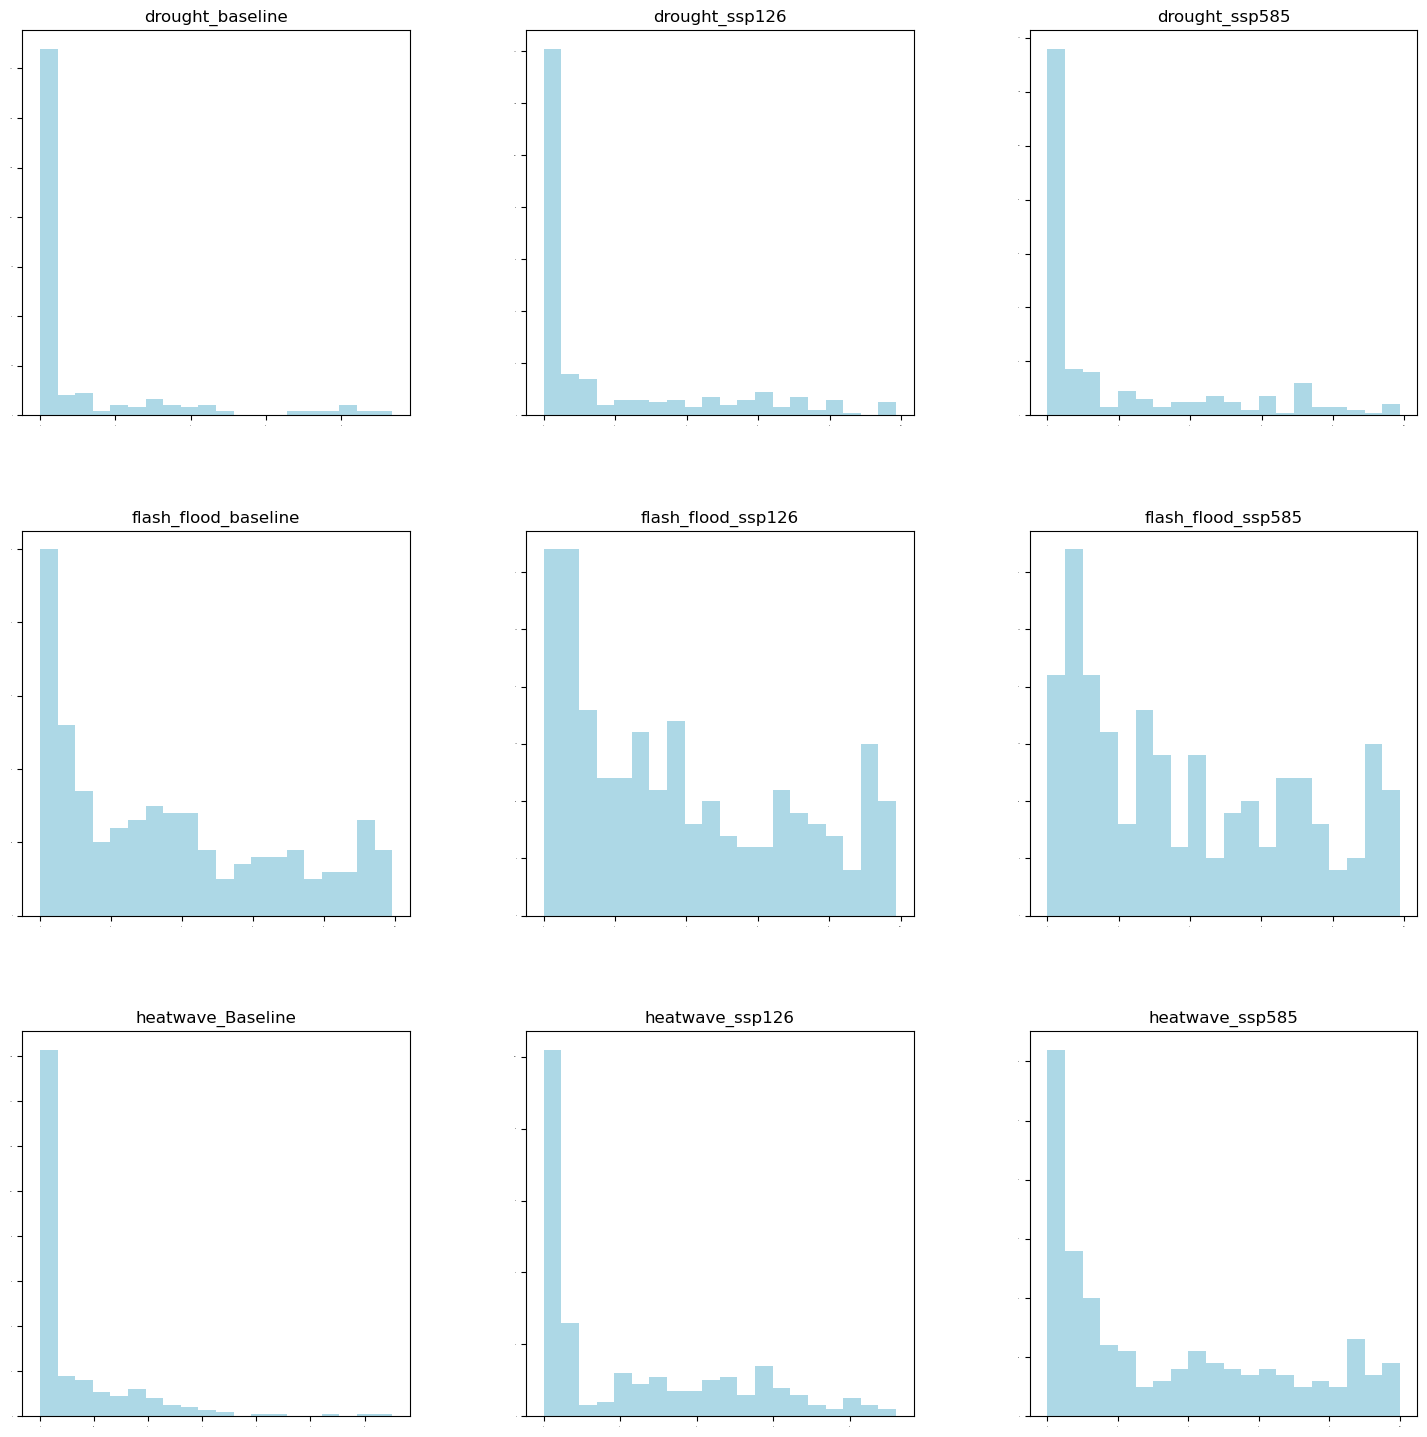

In [112]:
# Create histograms for each hazard in each scenario
country_exposure_piv.hist(bins=20,
       figsize=(18,18), 
       color='lightblue', 
       xlabelsize=0, 
       ylabelsize=0, 
       grid=False
      )
plt.show()

#### Cumulative Spending on Material (Bar Chart)

In [64]:
# Calculate the sum of spending for each material
result_df = client_inputs.groupby('material')['spend_on_material'].sum().reset_index()
result_df

,material,spend_on_material
0,Aluminium,1458042373
1,Electronic components,1189700577
2,Silver,1832326295
3,Steel,1422269295
4,Wood pulp and paper,1540946756


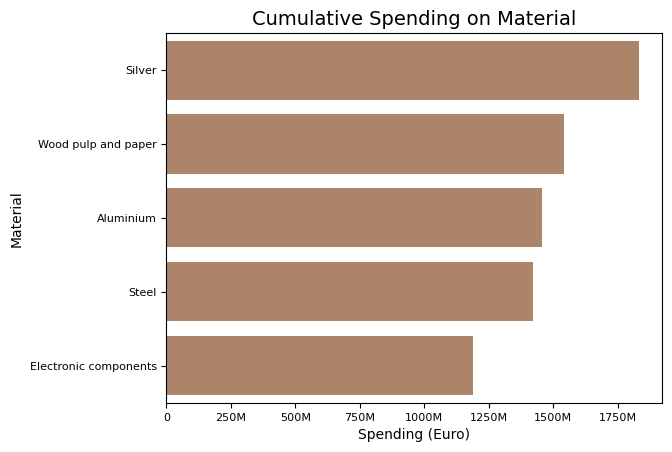

In [65]:
#create a horizontal bar chart showing the cumulative spending on material
g = sns.barplot(y="material", x="spend_on_material", data=result_df, color="#b7825f", order=result_df.sort_values('spend_on_material', ascending=False).material)

g.set_title('Cumulative Spending on Material', fontsize=14)
g.set(xlabel='Spending (Euro)', ylabel='Material')
g.tick_params(axis='both', which='major', labelsize=8)

# Format axis labels "25k"
def format_func(value, tick_number):
    if value >= 1e6:
        return f'{value / 1e6:.0f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.0f}k'
    else:
        return str(int(value))

g.xaxis.set_major_formatter(mtick.FuncFormatter(format_func))

plt.show()

### 2.6. Joining Datasets

In [66]:
# Join client input with country exposure by iso3 code
merged_df = client_inputs.merge(country_exposure_piv, on='iso3_code', how='left')
merged_df

,id,material,supplier_name,country_x,spend_on_material,units,iso3_code,country_y,drought_baseline,drought_ssp126,drought_ssp585,flash_flood_baseline,flash_flood_ssp126,flash_flood_ssp585,heatwave_Baseline,heatwave_ssp126,heatwave_ssp585
0,1,Aluminium,"Watsica, Strosin and Baumbach",Estonia,37607125,Euro,EST,Estonia,0.000000,0.000000,0.000000,3.233739,4.084532,5.136197,0.000000,3.628429,5.896280
1,2,Aluminium,"Haley, DuBuque and Wintheiser",Chile,21290394,Euro,CHL,Chile,0.000000,3.116353,7.522583,24.848022,24.329183,22.438484,0.000000,0.000000,0.000000
2,3,Aluminium,Douglas and Sons,Tunisia,65281324,Euro,TUN,Tunisia,13.824463,NaN,NaN,2.052942,NaN,NaN,61.328197,NaN,NaN
3,4,Aluminium,Douglas and Sons,India,54320093,Euro,IND,India,17.885335,45.540365,47.802734,51.298953,55.505847,56.199963,26.109888,65.877821,79.306549
4,5,Aluminium,"Zulauf, Prosacco and Metz",Hong Kong,37045883,Euro,HKG,Hong Kong S.A.R.,0.812785,3.657277,4.266993,75.218360,79.528523,78.438925,0.000425,5.137819,18.234040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,Wood pulp and paper,"Rice, Goldner and Davis",Indonesia,14168590,Euro,IDN,Indonesia,0.000000,4.336548,5.150350,70.212018,72.061225,71.696529,0.000000,6.333700,19.077921
196,197,Wood pulp and paper,"Hilpert, Gibson and Auer",South Africa,11626144,Euro,ZAF,South Africa,1.625570,38.216146,40.445964,31.257850,31.267727,33.612256,18.732801,58.759861,84.865162
197,198,Wood pulp and paper,Hudson Group,Chile,21089158,Euro,CHL,Chile,0.000000,3.116353,7.522583,24.848022,24.329183,22.438484,0.000000,0.000000,0.000000
198,199,Wood pulp and paper,"Cole, Stanton and Hirthe",Sri Lanka,17075172,Euro,LKA,Sri Lanka,0.000000,8.127848,9.753418,59.420543,60.825275,67.176860,0.574436,6.521739,17.139057


In [67]:
# Finding NaN values (we removed exposure level greater than 100 but other scenarios remained)
missing_rows = merged_df[merged_df.isna().any(axis=1)]
missing_rows

,id,material,supplier_name,country_x,spend_on_material,units,iso3_code,country_y,drought_baseline,drought_ssp126,drought_ssp585,flash_flood_baseline,flash_flood_ssp126,flash_flood_ssp585,heatwave_Baseline,heatwave_ssp126,heatwave_ssp585
2,3,Aluminium,Douglas and Sons,Tunisia,65281324,Euro,TUN,Tunisia,13.824463,NaN,NaN,2.052942,NaN,NaN,61.328197,NaN,NaN
18,19,Aluminium,Kihn and Sons,Algeria,2836142,Euro,DZA,Algeria,19.512939,52.034505,NaN,0.718527,0.923820,NaN,14.669327,83.342506,NaN
23,24,Aluminium,"Zulauf, Prosacco and Metz",Cyprus,9784906,Euro,CYP,Cyprus,NaN,NaN,70.320638,NaN,NaN,16.626109,NaN,NaN,23.069162
37,38,Aluminium,Beer Group,Iraq,46252300,Euro,IRQ,Iraq,86.572266,61.580404,NaN,2.724242,4.285639,NaN,29.687213,85.186204,NaN
44,45,Electronic components,"Bosco, Kertzmann and Cole",Algeria,55803197,Euro,DZA,Algeria,19.512939,52.034505,NaN,0.718527,0.923820,NaN,14.669327,83.342506,NaN
49,50,Electronic components,"Bins, King and Kutch",Cyprus,33136407,Euro,CYP,Cyprus,NaN,NaN,70.320638,NaN,NaN,16.626109,NaN,NaN,23.069162
61,62,Electronic components,Nolan Inc,Cyprus,72736974,Euro,CYP,Cyprus,NaN,NaN,70.320638,NaN,NaN,16.626109,NaN,NaN,23.069162
62,63,Electronic components,"Zulauf, Prosacco and Metz",Cyprus,33294880,Euro,CYP,Cyprus,NaN,NaN,70.320638,NaN,NaN,16.626109,NaN,NaN,23.069162
67,68,Electronic components,Wintheiser - Reichert,Cyprus,59777190,Euro,CYP,Cyprus,NaN,NaN,70.320638,NaN,NaN,16.626109,NaN,NaN,23.069162
68,69,Electronic components,"Cole, Stanton and Hirthe",Norway,29719425,Euro,NOR,Norway,0.000000,NaN,NaN,4.271617,NaN,NaN,0.000000,NaN,NaN


In [68]:
# Remove rows with NaN values in the 'iso3_code' column
merged_df = merged_df.dropna()
merged_df.shape

(182, 17)

In [69]:
# Joining with material vulnerability dataset
merged_df2 = merged_df.merge(mat_vuln, on='material', how='left')
merged_df2

,id_x,material,supplier_name,country_x,spend_on_material,units,iso3_code,country_y,drought_baseline,drought_ssp126,...,heatwave_Baseline,heatwave_ssp126,heatwave_ssp585,id_y,heatwave,drought,freeze,flash_flood,hurricane,windstorm
0,1,Aluminium,"Watsica, Strosin and Baumbach",Estonia,37607125,Euro,EST,Estonia,0.000000,0.000000,...,0.000000,3.628429,5.896280,1,30,30,10,50,50,20
1,2,Aluminium,"Haley, DuBuque and Wintheiser",Chile,21290394,Euro,CHL,Chile,0.000000,3.116353,...,0.000000,0.000000,0.000000,1,30,30,10,50,50,20
2,4,Aluminium,Douglas and Sons,India,54320093,Euro,IND,India,17.885335,45.540365,...,26.109888,65.877821,79.306549,1,30,30,10,50,50,20
3,5,Aluminium,"Zulauf, Prosacco and Metz",Hong Kong,37045883,Euro,HKG,Hong Kong S.A.R.,0.812785,3.657277,...,0.000425,5.137819,18.234040,1,30,30,10,50,50,20
4,6,Aluminium,"Kris, Baumbach and Moen",Denmark,11328585,Euro,DNK,Denmark,0.000000,0.000000,...,0.000000,0.142892,0.881835,1,30,30,10,50,50,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,195,Wood pulp and paper,"Kris, Baumbach and Moen",Liechtenstein,16685370,Euro,LIE,Liechtenstein,0.000000,0.000000,...,0.000000,0.254397,2.223216,5,50,70,30,70,80,50
178,196,Wood pulp and paper,"Rice, Goldner and Davis",Indonesia,14168590,Euro,IDN,Indonesia,0.000000,4.336548,...,0.000000,6.333700,19.077921,5,50,70,30,70,80,50
179,197,Wood pulp and paper,"Hilpert, Gibson and Auer",South Africa,11626144,Euro,ZAF,South Africa,1.625570,38.216146,...,18.732801,58.759861,84.865162,5,50,70,30,70,80,50
180,198,Wood pulp and paper,Hudson Group,Chile,21089158,Euro,CHL,Chile,0.000000,3.116353,...,0.000000,0.000000,0.000000,5,50,70,30,70,80,50


## 3. Calculating Overall Risk Score


Overall Risk Score = ((MV_drought * HE_drought) + (MV_flood * HE_flood) + (MV_heatwave * HE_heatwave)) / 3

MV = Material Vulnerability and HE = Hazard Exposure Level

### 3.1. Calculating Hazard Risk Scores

In [70]:
# Calculate Risk Scores for Each Physical Risk

merged_df2['Risk_Score_Baseline_Drought'] = merged_df2['drought'] * merged_df2['drought_baseline']
merged_df2['Risk_Score_Baseline_Flood'] = merged_df2['flash_flood'] * merged_df2['flash_flood_baseline']
merged_df2['Risk_Score_Baseline_Heatwave'] = merged_df2['heatwave'] * merged_df2['heatwave_Baseline']

merged_df2['Risk_Score_SSP126_Drought'] = merged_df2['drought'] * merged_df2['drought_ssp126']
merged_df2['Risk_Score_SSP126_Flood'] = merged_df2['flash_flood'] * merged_df2['flash_flood_ssp126']
merged_df2['Risk_Score_SSP126_Heatwave'] = merged_df2['heatwave'] * merged_df2['heatwave_ssp126']

merged_df2['Risk_Score_SSP585_Drought'] = merged_df2['drought'] * merged_df2['drought_ssp585']
merged_df2['Risk_Score_SSP585_Flood'] = merged_df2['flash_flood'] * merged_df2['flash_flood_ssp585']
merged_df2['Risk_Score_SSP585_Heatwave'] = merged_df2['heatwave'] * merged_df2['heatwave_ssp585']


### 3.2. Scaling Risk Scores

In [71]:
# Define a function for Min-Max scaling
def min_max_scaling(series):
    min_val = series.min()
    max_val = series.max()
    scaled_series = 100 * (series - min_val) / (max_val - min_val)
    return scaled_series

# Apply Min-Max scaling to each of your risk score columns
columns_to_scale = [
    'Risk_Score_Baseline_Drought', 'Risk_Score_Baseline_Flood', 'Risk_Score_Baseline_Heatwave',
    'Risk_Score_SSP126_Drought', 'Risk_Score_SSP126_Flood', 'Risk_Score_SSP126_Heatwave',
    'Risk_Score_SSP585_Drought', 'Risk_Score_SSP585_Flood', 'Risk_Score_SSP585_Heatwave'
]

for column in columns_to_scale:
    merged_df2[column] = min_max_scaling(merged_df2[column])


### 3.3. Overall Risk Scores

In [72]:
# Calculating overall risk score for each scenario
merged_df2['Overall_Risk_Score_Baseline'] = (
    merged_df2['Risk_Score_Baseline_Drought'] +
    merged_df2['Risk_Score_Baseline_Flood'] +
    merged_df2['Risk_Score_Baseline_Heatwave']
) / 3

merged_df2['Overall_Risk_Score_SSP126'] = (
    merged_df2['Risk_Score_SSP126_Drought'] +
    merged_df2['Risk_Score_SSP126_Flood'] +
    merged_df2['Risk_Score_SSP126_Heatwave']
) / 3

merged_df2['Overall_Risk_Score_SSP585'] = (
    merged_df2['Risk_Score_SSP585_Drought'] +
    merged_df2['Risk_Score_SSP585_Flood'] +
    merged_df2['Risk_Score_SSP585_Heatwave']
) / 3

In [73]:
merged_df2

,id_x,material,supplier_name,country_x,spend_on_material,units,iso3_code,country_y,drought_baseline,drought_ssp126,...,Risk_Score_Baseline_Heatwave,Risk_Score_SSP126_Drought,Risk_Score_SSP126_Flood,Risk_Score_SSP126_Heatwave,Risk_Score_SSP585_Drought,Risk_Score_SSP585_Flood,Risk_Score_SSP585_Heatwave,Overall_Risk_Score_Baseline,Overall_Risk_Score_SSP126,Overall_Risk_Score_SSP585
0,1,Aluminium,"Watsica, Strosin and Baumbach",Estonia,37607125,Euro,EST,Estonia,0.000000,0.000000,...,0.000000,0.000000,2.894930,2.974966,0.000000,3.580489,3.624883,0.741814,1.956632,2.401791
1,2,Aluminium,"Haley, DuBuque and Wintheiser",Chile,21290394,Euro,CHL,Chile,0.000000,3.116353,...,0.000000,1.717773,17.613295,0.000000,4.480442,16.144241,0.000000,5.947974,6.443689,6.874894
2,4,Aluminium,Douglas and Sons,India,54320093,Euro,IND,India,17.885335,45.540365,...,57.082219,25.102425,40.279504,54.013537,28.471257,40.659547,48.755639,34.520450,39.798489,39.295481
3,5,Aluminium,"Zulauf, Prosacco and Metz",Hong Kong,37045883,Euro,HKG,Hong Kong S.A.R.,0.812785,3.657277,...,0.000930,2.015938,57.744587,4.212522,2.541417,56.807979,11.209821,18.225057,21.324349,23.519739
4,6,Aluminium,"Kris, Baumbach and Moen",Denmark,11328585,Euro,DNK,Denmark,0.000000,0.000000,...,0.000000,0.000000,3.981778,0.117158,0.040329,4.458688,0.542130,1.020251,1.366312,1.680382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,195,Wood pulp and paper,"Kris, Baumbach and Moen",Liechtenstein,16685370,Euro,LIE,Liechtenstein,0.000000,0.000000,...,0.000000,0.000000,26.268890,0.347636,0.000000,31.528284,2.277961,7.313762,8.872175,11.268748
178,196,Wood pulp and paper,"Rice, Goldner and Davis",Indonesia,14168590,Euro,IDN,Indonesia,0.000000,4.336548,...,0.000000,5.577507,73.271797,8.655051,7.157600,72.736578,19.547697,23.639344,29.168119,33.147292
179,197,Wood pulp and paper,"Hilpert, Gibson and Auer",South Africa,11626144,Euro,ZAF,South Africa,1.625570,38.216146,...,68.257019,49.152188,31.750755,80.295813,56.209002,34.020660,86.954887,33.928921,53.732919,59.061517
180,198,Wood pulp and paper,Hudson Group,Chile,21089158,Euro,CHL,Chile,0.000000,3.116353,...,0.000000,4.008138,24.688463,0.000000,10.454366,22.661566,0.000000,8.341999,9.565534,11.038644


## 4. Insights

### 4.1. Suppliers

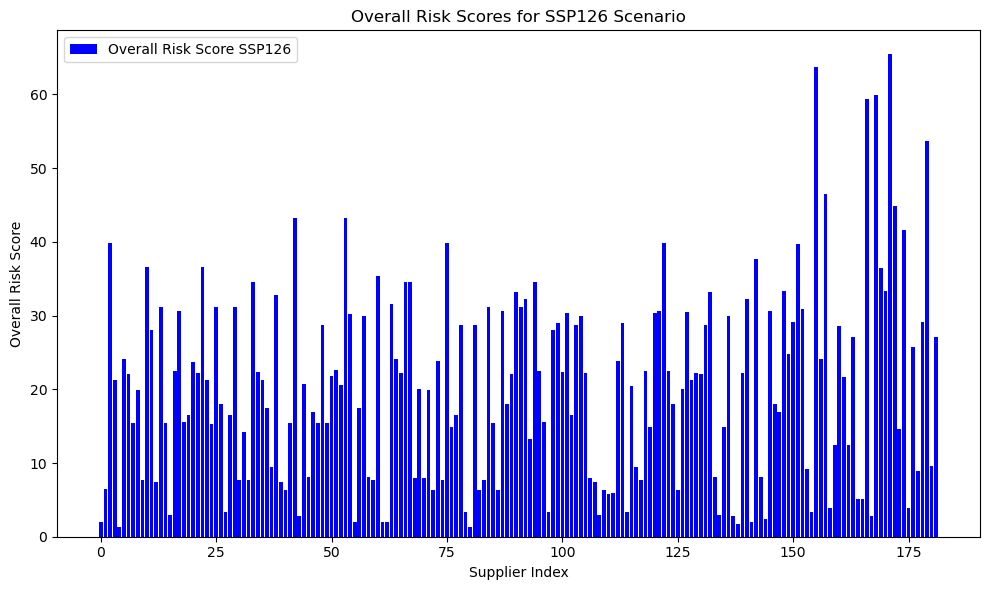

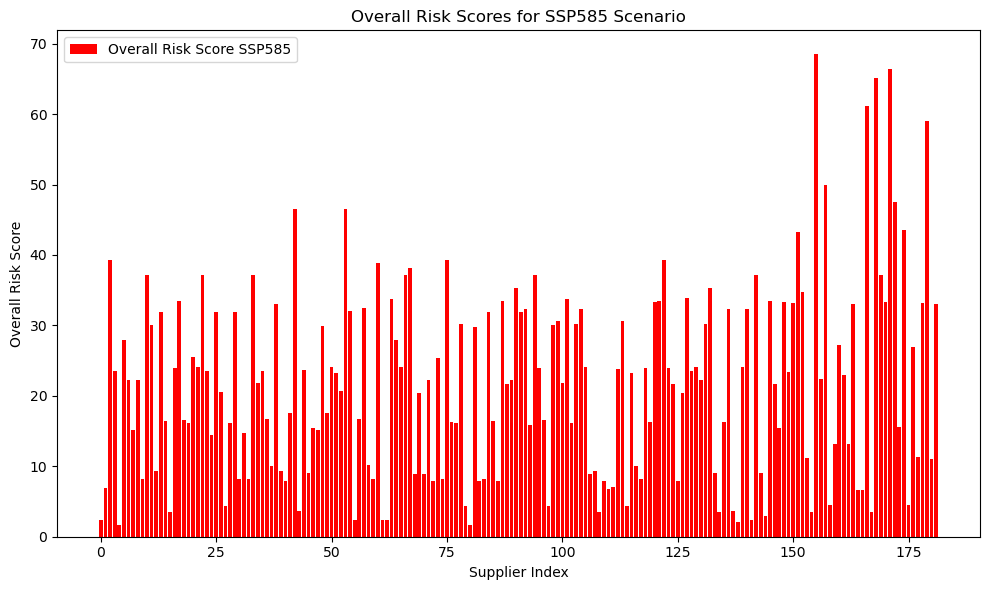

In [74]:
# Create a bar plot for overall risk scores under SSP126
plt.figure(figsize=(10, 6))
plt.bar(merged_df2.index, merged_df2['Overall_Risk_Score_SSP126'], label='Overall Risk Score SSP126', color='blue')
plt.xlabel('Supplier Index')
plt.ylabel('Overall Risk Score')
plt.title('Overall Risk Scores for SSP126 Scenario')
plt.legend()
plt.tight_layout()
plt.show()

# Create a bar plot for overall risk scores under SSP585
plt.figure(figsize=(10, 6))
plt.bar(merged_df2.index, merged_df2['Overall_Risk_Score_SSP585'], label='Overall Risk Score SSP585', color='red')
plt.xlabel('Supplier Index')
plt.ylabel('Overall Risk Score')
plt.title('Overall Risk Scores for SSP585 Scenario')
plt.legend()
plt.tight_layout()
plt.show()

### 4.2. Distribution of Risk Scores

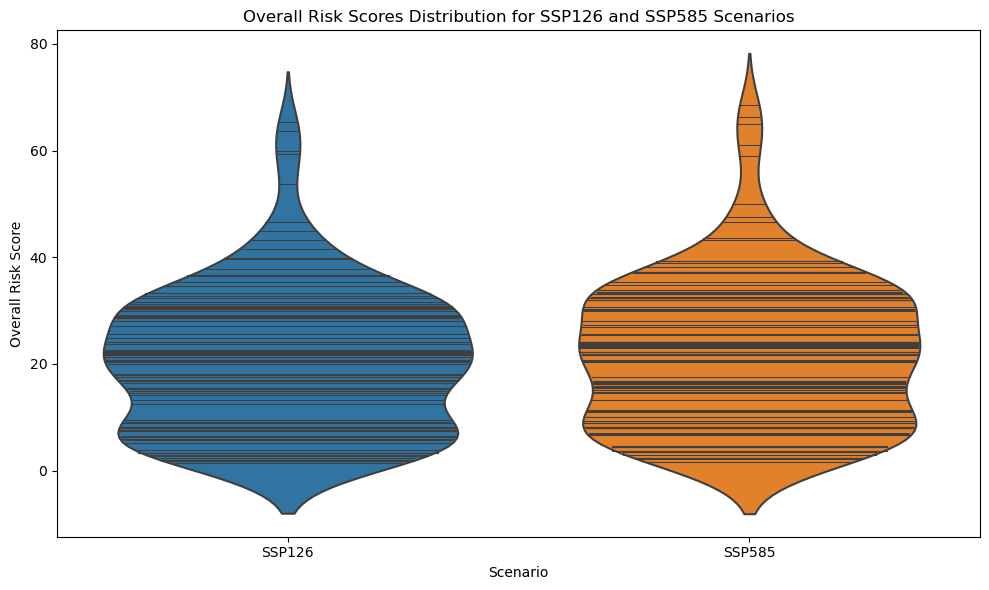

In [75]:
# Create a violin plot for overall risk scores under SSP126 and SSP585
plt.figure(figsize=(10, 6))
sns.violinplot(data=merged_df2[['Overall_Risk_Score_SSP126', 'Overall_Risk_Score_SSP585']], inner="stick")
plt.xlabel('Scenario')
plt.ylabel('Overall Risk Score')
plt.title('Overall Risk Scores Distribution for SSP126 and SSP585 Scenarios')
plt.xticks([0, 1], ['SSP126', 'SSP585'])
plt.tight_layout()
plt.show()

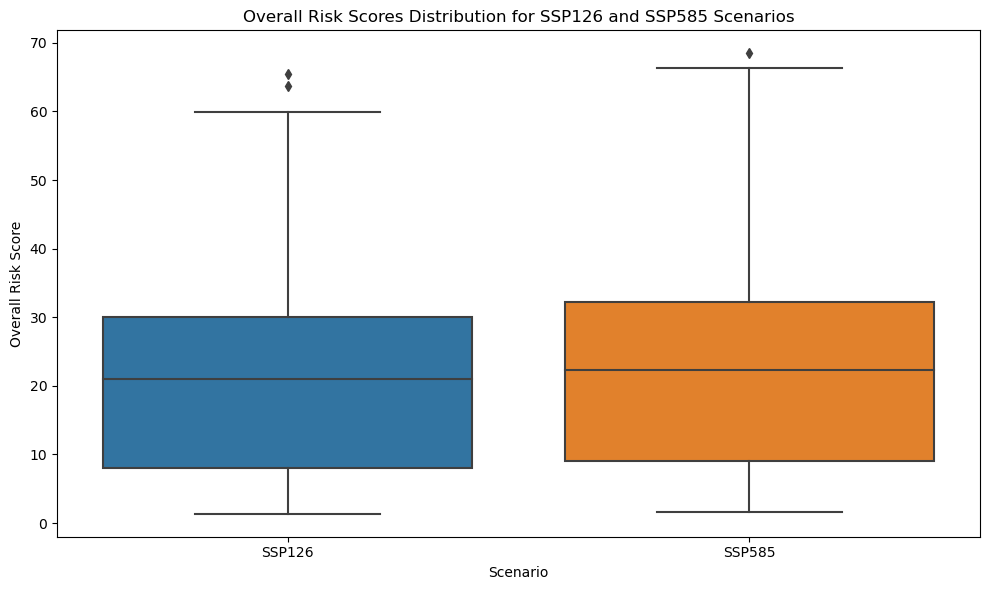

In [76]:
# Create a box plot for overall risk scores under SSP126 and SSP585
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df2[['Overall_Risk_Score_SSP126', 'Overall_Risk_Score_SSP585']])
plt.xlabel('Scenario')
plt.ylabel('Overall Risk Score')
plt.title('Overall Risk Scores Distribution for SSP126 and SSP585 Scenarios')
plt.xticks([0, 1], ['SSP126', 'SSP585'])
plt.tight_layout()
plt.show()

### 4.3. Comparing Baseline with Future Scenarios

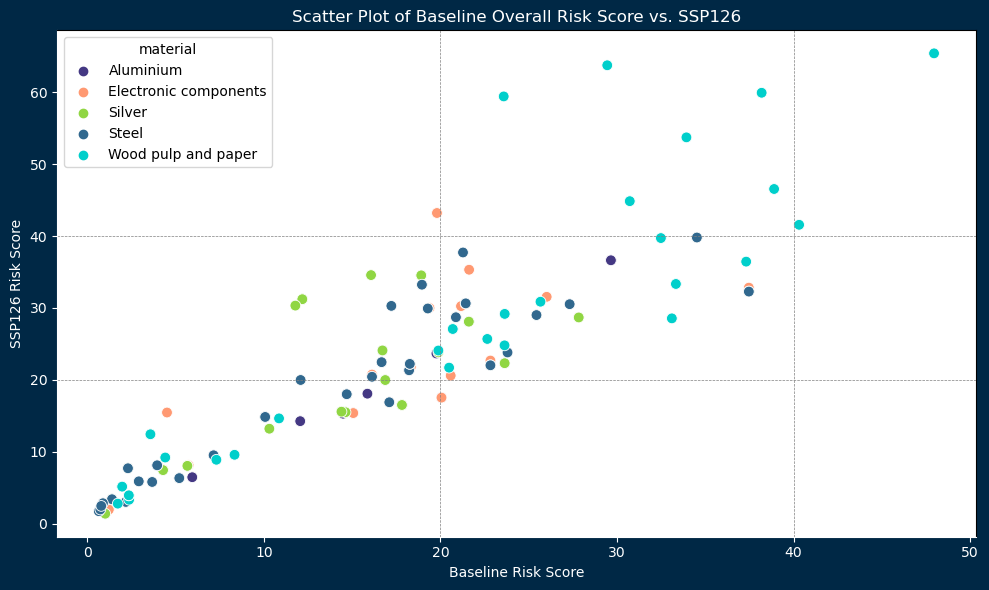

In [77]:
# Creating a scatter plot displaying the relationship between baseline 2020 and ssp126

custom_palette = ['#443883', '#ff9972', '#90d643', '#31688e', '#00cfcb']  

fig = plt.figure(figsize=(10, 6), facecolor='#002845')
ax = fig.add_subplot(111)

scatter = sns.scatterplot(data=merged_df2, x='Overall_Risk_Score_Baseline', y='Overall_Risk_Score_SSP126', hue='material', palette=custom_palette,s=60)

scatter.spines['bottom'].set_color('white')
scatter.spines['left'].set_color('white')
scatter.xaxis.label.set_color('white')
scatter.yaxis.label.set_color('white')

scatter.tick_params(axis='x', colors='white')
scatter.tick_params(axis='y', colors='white')

plt.xlabel('Baseline Risk Score', color='white')
plt.ylabel('SSP126 Risk Score', color='white')
plt.title('Scatter Plot of Baseline Overall Risk Score vs. SSP126', color='white')
plt.tight_layout()

ax.axvline(x=20, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=20, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=40, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=40, color='gray', linestyle='--', linewidth=0.5)

plt.savefig('scatter_plot_126.png', dpi=300, bbox_inches='tight')

plt.show()

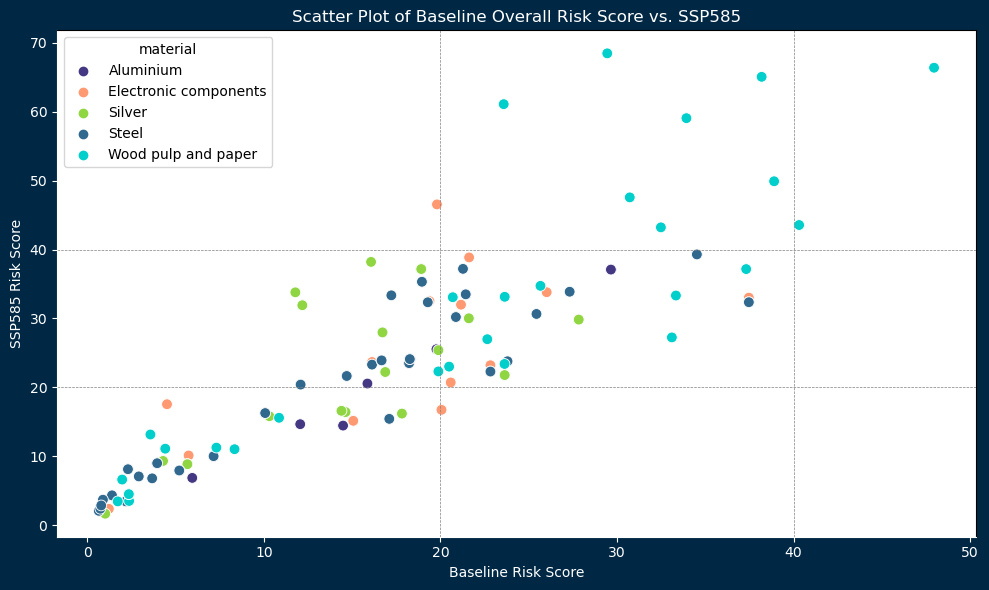

In [78]:
# Creating a scatter plot displaying the relationship between baseline 2020 and ssp585

custom_palette = ['#443883', '#ff9972', '#90d643', '#31688e', '#00cfcb']  

fig = plt.figure(figsize=(10, 6), facecolor='#002845')
ax = fig.add_subplot(111)

scatter = sns.scatterplot(data=merged_df2, x='Overall_Risk_Score_Baseline', y='Overall_Risk_Score_SSP585', hue='material', palette=custom_palette,s=60)

scatter.spines['bottom'].set_color('white')
scatter.spines['left'].set_color('white')
scatter.xaxis.label.set_color('white')
scatter.yaxis.label.set_color('white')

scatter.tick_params(axis='x', colors='white')
scatter.tick_params(axis='y', colors='white')

plt.xlabel('Baseline Risk Score', color='white')
plt.ylabel('SSP585 Risk Score', color='white')
plt.title('Scatter Plot of Baseline Overall Risk Score vs. SSP585', color='white')
plt.tight_layout()

ax.axvline(x=20, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=20, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=40, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=40, color='gray', linestyle='--', linewidth=0.5)

plt.savefig('scatter_plot_585.png', dpi=300, bbox_inches='tight')

plt.show()

### 4.4. Suppliers with the Highest Risk for both Scenarios

In [79]:
# Filter suppliers with high risk
filtered_df126 = merged_df2.loc[merged_df2['Overall_Risk_Score_SSP126'] > 40, 
                             ['material','country_x', 'spend_on_material', 'supplier_name', 'Overall_Risk_Score_Baseline', 'Overall_Risk_Score_SSP126']]

# Sorting by 'Overall_Risk_Score_SSP126' in descending order
filtered_df126 = filtered_df126.sort_values(by='Overall_Risk_Score_SSP126', ascending=False)

# Display the first few rows
filtered_df126

,material,country_x,spend_on_material,supplier_name,Overall_Risk_Score_Baseline,Overall_Risk_Score_SSP126
171,Wood pulp and paper,Australia,70520105,Tremblay - Ratke,47.949739,65.423771
155,Wood pulp and paper,Mexico,18015000,Schamberger - Balistreri,29.445706,63.763927
168,Wood pulp and paper,Saudi Arabia,72288746,"Sawayn, Weimann and Legros",38.187244,59.939422
166,Wood pulp and paper,Israel,61896193,Nolan Inc,23.582720,59.429866
179,Wood pulp and paper,South Africa,11626144,"Hilpert, Gibson and Auer",33.928921,53.732919
157,Wood pulp and paper,Thailand,64246916,Koch Inc,38.893391,46.549775
172,Wood pulp and paper,Vietnam,57124530,Bergnaum Group,30.720477,44.855476
42,Electronic components,Mexico,49952202,Leuschke - Nolan,19.802927,43.208815
53,Electronic components,Mexico,4500772,"Witting, Hudson and Schowalter",19.802927,43.208815
174,Wood pulp and paper,Japan,69107133,"Hilpert, Gibson and Auer",40.309361,41.567238


In [80]:
#filter suppliers with high risk

filtered_df585 = merged_df2.loc[merged_df2['Overall_Risk_Score_SSP585'] > 40, 
                             ['material','country_x', 'spend_on_material', 'supplier_name', 'Overall_Risk_Score_Baseline', 'Overall_Risk_Score_SSP585']]

# Sorting by 'Overall_Risk_Score_SSP126' in descending order
filtered_df585 = filtered_df585.sort_values(by='Overall_Risk_Score_SSP585', ascending=False)

# Display the first few rows
filtered_df585

,material,country_x,spend_on_material,supplier_name,Overall_Risk_Score_Baseline,Overall_Risk_Score_SSP585
155,Wood pulp and paper,Mexico,18015000,Schamberger - Balistreri,29.445706,68.464416
171,Wood pulp and paper,Australia,70520105,Tremblay - Ratke,47.949739,66.378221
168,Wood pulp and paper,Saudi Arabia,72288746,"Sawayn, Weimann and Legros",38.187244,65.059927
166,Wood pulp and paper,Israel,61896193,Nolan Inc,23.582720,61.093136
179,Wood pulp and paper,South Africa,11626144,"Hilpert, Gibson and Auer",33.928921,59.061517
157,Wood pulp and paper,Thailand,64246916,Koch Inc,38.893391,49.907594
172,Wood pulp and paper,Vietnam,57124530,Bergnaum Group,30.720477,47.569804
42,Electronic components,Mexico,49952202,Leuschke - Nolan,19.802927,46.550969
53,Electronic components,Mexico,4500772,"Witting, Hudson and Schowalter",19.802927,46.550969
174,Wood pulp and paper,Japan,69107133,"Hilpert, Gibson and Auer",40.309361,43.560090


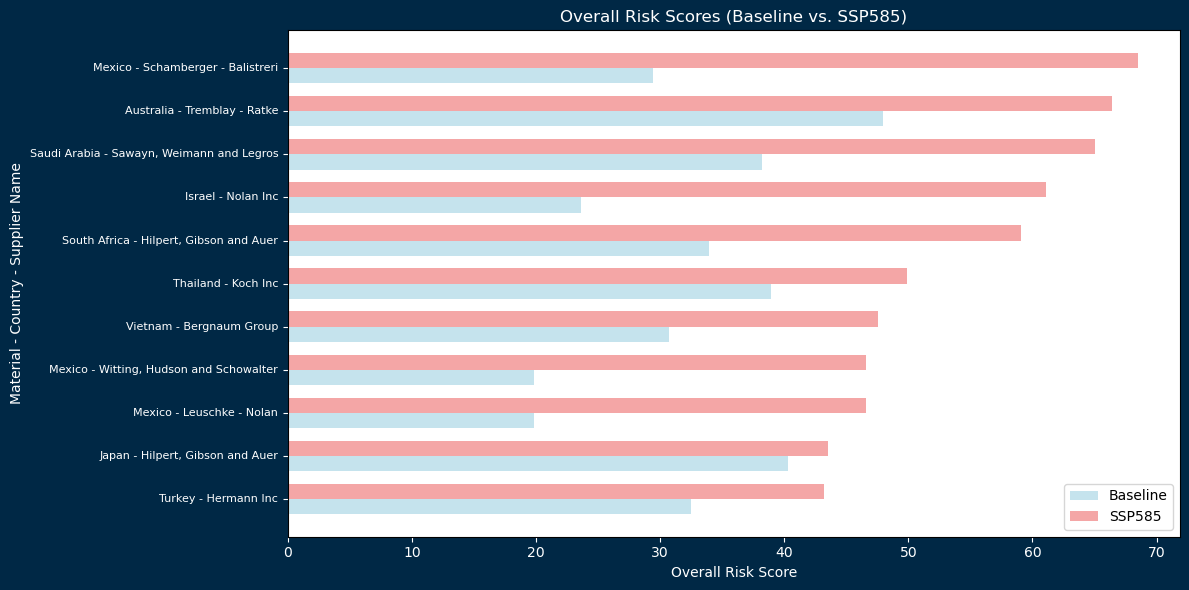

In [114]:
# Group the data
grouped_df585 = filtered_df585.groupby(['country_x', 'supplier_name'])[['Overall_Risk_Score_Baseline', 'Overall_Risk_Score_SSP585']].sum().reset_index()

# Sort the data
grouped_df585 = grouped_df585.sort_values(by='Overall_Risk_Score_SSP585', ascending=True)

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#002845')
labels = grouped_df585.apply(lambda x: f"{x['country_x']} - {x['supplier_name']}", axis=1)
y = np.arange(len(labels))
bar_height = 0.35

# Plot two bars
baseline_scores = grouped_df585['Overall_Risk_Score_Baseline']
ssp585_scores = grouped_df585['Overall_Risk_Score_SSP585']

# Define the colors
baseline_color = 'lightblue'  # Blueish color for Baseline
ssp585_color = 'lightcoral'  # Light red color for SSP126

ax.barh(y - bar_height/2, baseline_scores, label='Baseline', height=bar_height, align='center', alpha=0.7, color=baseline_color)
ax.barh(y + bar_height/2, ssp585_scores, label='SSP585', height=bar_height, align='center', alpha=0.7, color=ssp585_color)

# Customize the plot
ax.set_ylabel('Material - Country - Supplier Name', color='white')  # Set text color to white
ax.set_xlabel('Overall Risk Score', color='white')  # Set text color to white
ax.set_title('Overall Risk Scores (Baseline vs. SSP585)', color='white')  # Set text color to white
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=8, va='center', color='white')  # Set text color to white

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

legend = ax.legend()
for text in legend.get_texts():
    text.set_color('black')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.tight_layout()
plt.show()


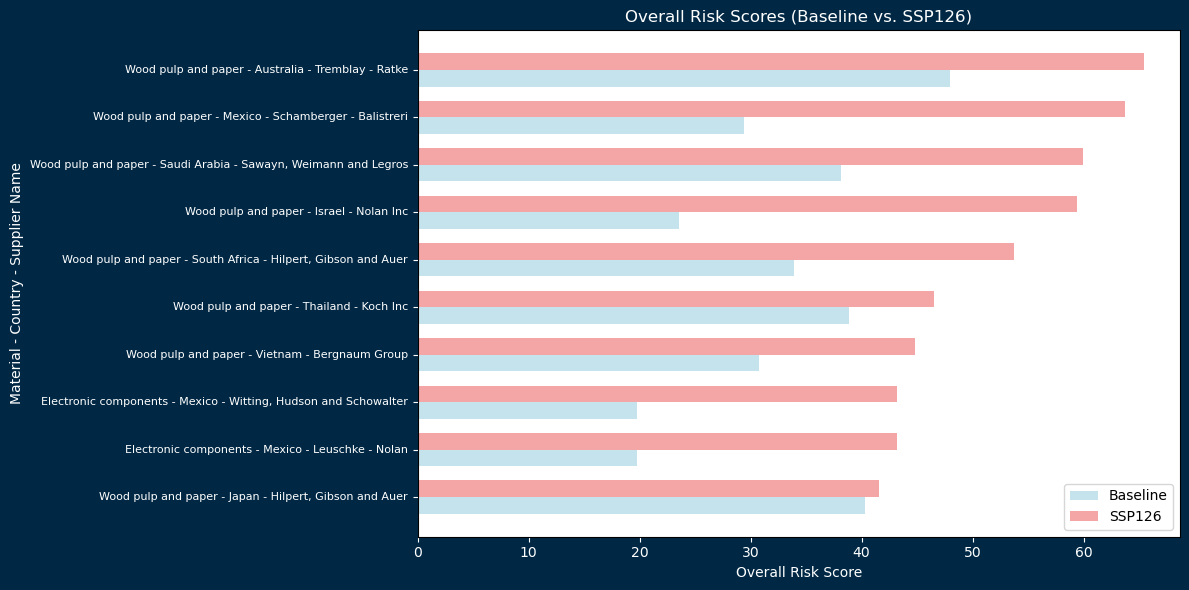

In [82]:
# Group the data
grouped_df126 = filtered_df126.groupby(['material','country_x', 'supplier_name'])[['Overall_Risk_Score_Baseline', 'Overall_Risk_Score_SSP126']].sum().reset_index()

# Sort the data
grouped_df126 = grouped_df126.sort_values(by='Overall_Risk_Score_SSP126', ascending=True)

# Create a horizontal chart
fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#002845')
labels = grouped_df126.apply(lambda x: f"{x['material']} - {x['country_x']} - {x['supplier_name']}", axis=1)
y = np.arange(len(labels))
bar_height = 0.35

# Plot the separate bars
baseline_scores = grouped_df126['Overall_Risk_Score_Baseline']
ssp126_scores = grouped_df126['Overall_Risk_Score_SSP126']

baseline_color = 'lightblue'  # Blueish color for Baseline
ssp126_color = 'lightcoral'  # Light red color for SSP126

ax.barh(y - bar_height/2, baseline_scores, label='Baseline', height=bar_height, align='center', alpha=0.7, color=baseline_color)
ax.barh(y + bar_height/2, ssp126_scores, label='SSP126', height=bar_height, align='center', alpha=0.7, color=ssp126_color)

ax.set_ylabel('Material - Country - Supplier Name', color='white')  # Set text color to white
ax.set_xlabel('Overall Risk Score', color='white')  # Set text color to white
ax.set_title('Overall Risk Scores (Baseline vs. SSP126)', color='white')  # Set text color to white
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=8, va='center', color='white')  # Set text color to white

ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

legend = ax.legend()
for text in legend.get_texts():
    text.set_color('black')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Show the plot
plt.tight_layout()
plt.show()



In [83]:
# Calculate Pearson correlation coefficients
corr_ssp126 = np.corrcoef(merged_df2['spend_on_material'], merged_df2['Overall_Risk_Score_SSP126'])[0, 1]
corr_ssp585 = np.corrcoef(merged_df2['spend_on_material'], merged_df2['Overall_Risk_Score_SSP585'])[0, 1]

print(f"Pearson Correlation (SSP126): {corr_ssp126:.2f}")
print(f"Pearson Correlation (SSP585): {corr_ssp585:.2f}")

Pearson Correlation (SSP126): 0.13
Pearson Correlation (SSP585): 0.12


Both of these correlation coefficients are relatively low, close to zero. This suggests that there is a weak linear relationship between spending on material and overall risk scores for both SSP126 and SSP585 scenarios. In other words, there isn't a strong linear correlation between how much is spent on materials and the overall risk scores.

### 4.5. Risk Scores and Spending on Materials

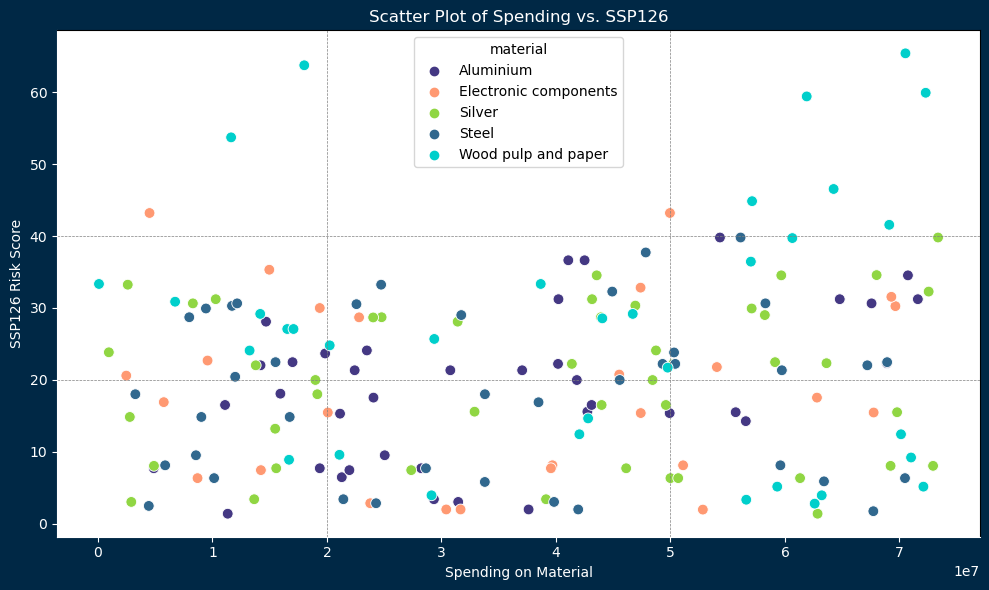

In [84]:
# Creating scatter plot displaying the relationship between spending and ssp126

custom_palette = ['#443883', '#ff9972', '#90d643', '#31688e', '#00cfcb']  
fig = plt.figure(figsize=(10, 6), facecolor='#002845')
ax = fig.add_subplot(111)
scatter = sns.scatterplot(data=merged_df2, x='spend_on_material', y='Overall_Risk_Score_SSP126', hue='material', palette=custom_palette,s=60)

scatter.spines['bottom'].set_color('white')
scatter.spines['left'].set_color('white')
scatter.xaxis.label.set_color('white')
scatter.yaxis.label.set_color('white')

scatter.tick_params(axis='x', colors='white')
scatter.tick_params(axis='y', colors='white')

plt.xlabel('Spending on Material', color='white')
plt.ylabel('SSP126 Risk Score', color='white')
plt.title('Scatter Plot of Spending vs. SSP126', color='white')
plt.tight_layout()

ax.axvline(x=20000000, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=20, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=50000000, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=40, color='gray', linestyle='--', linewidth=0.5)

plt.savefig('spending_scatter_126.png', dpi=300, bbox_inches='tight')

plt.show()

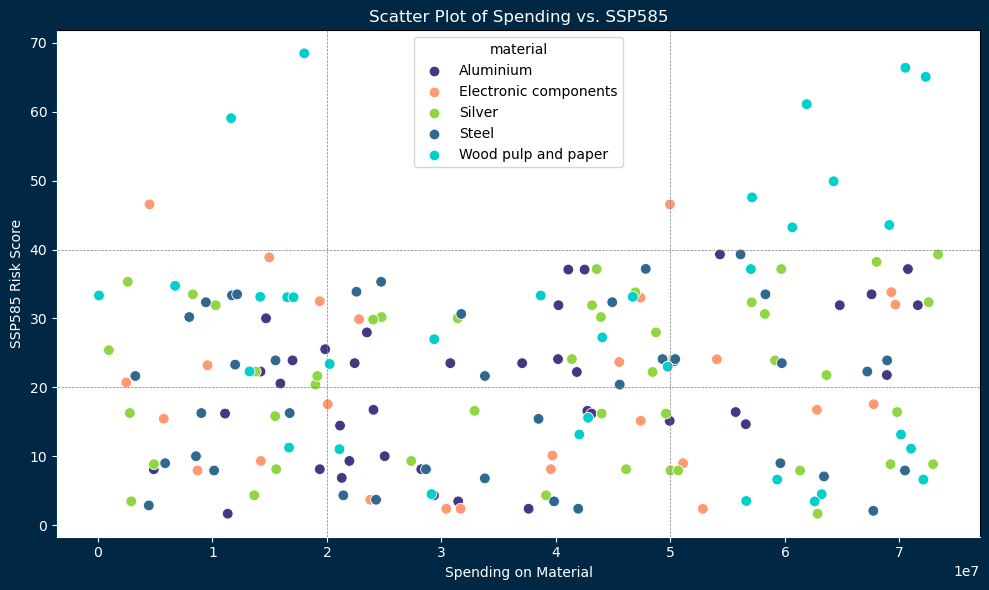

In [85]:
#creating scatter plot displaying the relationship between spending and ssp585

custom_palette = ['#443883', '#ff9972', '#90d643', '#31688e', '#00cfcb']  

fig = plt.figure(figsize=(10, 6), facecolor='#002845')
ax = fig.add_subplot(111)


scatter = sns.scatterplot(data=merged_df2, x='spend_on_material', y='Overall_Risk_Score_SSP585', hue='material', palette=custom_palette,s=60)

scatter.spines['bottom'].set_color('white')
scatter.spines['left'].set_color('white')
scatter.xaxis.label.set_color('white')
scatter.yaxis.label.set_color('white')

scatter.tick_params(axis='x', colors='white')
scatter.tick_params(axis='y', colors='white')

plt.xlabel('Spending on Material', color='white')
plt.ylabel('SSP585 Risk Score', color='white')
plt.title('Scatter Plot of Spending vs. SSP585', color='white')
plt.tight_layout()

ax.axvline(x=20000000, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=20, color='gray', linestyle='--', linewidth=0.5)
ax.axvline(x=50000000, color='gray', linestyle='--', linewidth=0.5)
ax.axhline(y=40, color='gray', linestyle='--', linewidth=0.5)

plt.savefig('spending_scatter_585.png', dpi=300, bbox_inches='tight')

plt.show()

## 5. Preparation for Mapping

### 5.1. Grouping overall risk score (which was by suppliers) into countries

In [86]:
# Group by 'country_x' and 'iso3_code', and calculate the mean of overall risk scores for each country
country_mean_scores = merged_df2.groupby(['country_x', 'iso3_code'])[['Overall_Risk_Score_Baseline', 'Overall_Risk_Score_SSP126', 'Overall_Risk_Score_SSP585']].mean().reset_index()

# Reset the index to make it a regular index instead of an index
country_mean_scores.reset_index(drop=True, inplace=True)

In [87]:
country_mean_scores

,country_x,iso3_code,Overall_Risk_Score_Baseline,Overall_Risk_Score_SSP126,Overall_Risk_Score_SSP585
0,American Samoa,ASM,30.155198,30.156361,30.153998
1,Argentina,ARG,23.636791,22.307890,21.795037
2,Australia,AUS,35.752022,46.228180,46.857007
3,Austria,AUT,5.741135,8.106400,10.127262
4,Bangladesh,BGD,21.277344,37.716580,37.201347
...,...,...,...,...,...
60,Turkey,TUR,26.184332,31.773481,34.313047
61,United Arab Emirates (the),ARE,11.785226,30.325120,33.793094
62,United Kingdom,GBR,2.371131,3.313179,3.530737
63,United States,USA,20.581401,20.582715,20.723670


### 5.2. Joining overall risk with country boundaries

In [108]:
# Joining country boundary shp with overall risk scores
result = world_boundary.merge(country_mean_scores, on='iso3_code', how='left')
result = result.dropna()


In [109]:
# Change column names
result = result.rename(columns ={"country_x":"country","Overall_Risk_Score_Baseline":"risk_base","Overall_Risk_Score_SSP126":"risk_126","Overall_Risk_Score_SSP585":"risk_585"})

In [110]:
result

,iso3_code,color_code,name,geometry,country,risk_base,risk_126,risk_585
2,IRL,IRL,Ireland,"MULTIPOLYGON (((-9.97014 54.02083, -9.93833 53...",Ireland,2.184670,3.004658,3.469283
6,ESP,ESP,Spain,"MULTIPOLYGON (((-17.91125 27.77375, -17.96389 ...",Spain,25.727360,25.034051,25.460249
8,MAC,CHN,Macao,"MULTIPOLYGON (((113.55143 22.16339, 113.55424 ...",Macao,18.266472,22.212690,24.108607
16,CHE,CHE,Switzerland,"POLYGON ((9.56672 47.54045, 9.55980 47.50209, ...",Switzerland,5.672443,8.025509,8.860703
18,AUT,AUT,Austria,"POLYGON ((16.94618 48.61907, 16.94333 48.57333...",Austria,5.741135,8.106400,10.127262
...,...,...,...,...,...,...,...,...
236,BEL,BEL,Belgium,"POLYGON ((6.01180 50.75727, 6.05472 50.72361, ...",Belgium,1.595238,3.964449,5.107669
239,ISR,ISR,Israel,"POLYGON ((35.62364 33.24573, 35.63249 33.24637...",Israel,14.080422,35.917302,36.784958
241,MEX,MEX,Mexico,"MULTIPOLYGON (((-91.82862 18.63916, -91.83446 ...",Mexico,23.017187,50.060519,53.855452
242,ROU,ROU,Romania,"POLYGON ((28.21484 45.44865, 28.22698 45.44938...",Romania,19.058640,20.038846,18.933847


### 5.3. Exporting shapefile for R to create maps

In [111]:
output_shapefile = 'Data/output_shapefile.shp'

# Export the shp
result.to_file(output_shapefile)